In [80]:
import graspy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import itertools
import seaborn as sns

In [3]:
from graspy.embed import LaplacianSpectralEmbed as lapSE
from graspy.embed import AdjacencySpectralEmbed as adjSE
from graspy.simulations import sbm
from graspy.plot import heatmap,pairplot
from sklearn.cluster import KMeans

In [273]:
def lineGraph(adj):
    """
    Computes the undirected line graph from an undirected adjacency matrix.
    Returns the adjacency matrix of the line graph and a dictionary mapping edges in the graph to nodes in the line graph
    """
    G = nx.from_numpy_array(adj,create_using=nx.Graph)
    lG = nx.Graph()
    eDict = {}
    for c,(i,j) in enumerate(G.edges()):
        lG.add_node(c)
        G[i][j]['index'] = c
        eDict[(i,j)] = c                                                                                                        

    visited = []
    for n in G.nodes():
        neighs = [neigh for neigh in G.neighbors(n) if not neigh in visited]
        for i,j in itertools.combinations(neighs, 2):
            lG.add_edge(G[n][i]['index'],G[n][j]['index'])
        #visited.append(n)
                    
    return(eDict,nx.adjacency_matrix(lG).toarray())

In [20]:
def lineDiGraph(adj):
    """
    Computes the directed line graph from a directed adjacency matrix.
    Returns the adjacency matrix of the line graph and a dictionary mapping edges in the graph to nodes in the line graph
    """
    G = nx.from_numpy_array(adj,create_using=nx.DiGraph)
    lG = nx.DiGraph()
    eDict = {}
    for c,(i,j) in enumerate(G.edges()):
        lG.add_node(c)
        G[i][j]['index'] = c
        eDict[(i,j)] = c                                                                                                        
    
    for n in G.nodes():
        in_nodes = [i for i,j in G.in_edges(n)]
        out_nodes = [o for j,o in G.out_edges(n)]
        for i,o in itertools.product(in_nodes,out_nodes):
            lG.add_edge(G[i][n]['index'],G[n][o]['index'])
                    
    return(eDict,nx.adjacency_matrix(lG).toarray())

In [229]:
def random_graph(ns, params, distribution=np.random.beta,directed=False):
    """
    Creates a block model graph whose edges are probabilistically determined by the input distribution and parameters.
    ns is an array-like object of the sizes of each block
    """
    n = sum(ns)
    adj = np.zeros((n,n))
    for r in range(len(ns)):
        for c in range(len(ns)):
            param = params[r][c]
            start_r = sum(ns[:r])
            start_c = sum(ns[:c])
            for i in range(ns[r]):
                for j in range(i+1,ns[c]):
                    if i == j:
                        continue
                    if distribution(*param) > np.random.uniform():
                        adj[i+start_r][j+start_c] = 1
                        if not directed:
                            adj[j+start_c][i+start_r] = 1
                    if directed and distribution(*param) > np.random.uniform():
                        adj[j+start_c][i+start_r] = 1
                        
    return(adj)

In [95]:
def edgelabels2heatmap(adj,labels,bDict,title='',directed=False):
    """
    Colors an adjacency matrix by the labeling of the vertices in the line graph.
    """
    color_mat = np.zeros(adj.shape)
    for (i,j) in bDict.keys():
        color_mat[i][j] = (labels[bDict[(i,j)]]+1)/max(labels)
        if not directed:
            color_mat[j][i] = (labels[bDict[(i,j)]]+1)/max(labels)
    fig = heatmap(color_mat, title=title)
    return(fig)

In [8]:
def nodelabels2heatmap(adj,labels):
    color_mat = np.zeros(adj.shape)
    for i in range(len(labels)):
        for j in range(i,len(labels)):
            if beta[i][j] == 0:
                continue
            if labels[i] == labels[j]:
                label = labels[i]
            else:
                label = 2
            color_mat[i][j] = label + 1
            color_mat[j][i] = label + 1
    plt.imshow(color_mat,cmap='CMRmap')

## Undirected Graph

In [314]:
ns = [50,50]
params = [[(0.5,0.5),(2,5)],[(2,5),(4,2)]]
#params = [[(2,1),(2,5),(1,5)],[(2,5),(2,1),(2,5)],[(1,5),(2,5),(3,1)]]

In [315]:
beta_adj = random_graph(ns,params,directed=False)

In [ ]:
edge_dict,line_graph = lineGraph(beta_adj)

In [ ]:
n = None
lse = lapSE(n_components=n).fit_transform(line_graph)
#ase = adjSE(n_components=n).fit_transform(line_graph)

In [ ]:
pairplot(lse,title='')#LineGraph LSE Embedding of Adjacencies Sampled from Betas')

In [ ]:
#lse_labels = graspy.cluster.KMeansCluster(6).fit_predict(lse)
lse_labels = graspy.cluster.GaussianCluster(3).fit_predict(lse)

In [ ]:
pairplot(lse,
         Y=lse_labels,
         title='',#LSE Embedded LineGraph colored by GMM labels',
         palette='muted')#.savefig("./plots./lse_pairplot_3by3_beta.png")

In [ ]:
fig = edgelabels2heatmap(beta_adj,lse_labels,edge_dict,title='Edges Colored by GMM labels of LSE LineGraph Embedding',directed=False)#.get_figure().savefig("./plots./lse_adj_heatmap_3by3_beta.png")

## Directed Graph

In [263]:
ns = [50,50]
params = [[(0.5,0.5),(2,5)],[(2,5),(4,2)]]
#params = [[(2,1),(2,5),(1,5)],[(2,5),(2,1),(2,5)],[(1,5),(2,5),(3,1)]]

In [283]:
beta_adj_di = random_graph(ns,params,directed=True)

In [284]:
edge_dict_di,line_graph_di = lineDiGraph(beta_adj_di)

In [287]:
n = None
ase_full = adjSE(n_components=n).fit_transform(line_graph_di)
ase_di = np.concatenate(ase_full,axis=1)

In [292]:
ase_labels_di = graspy.cluster.GaussianCluster(4).fit_predict(ase_di)

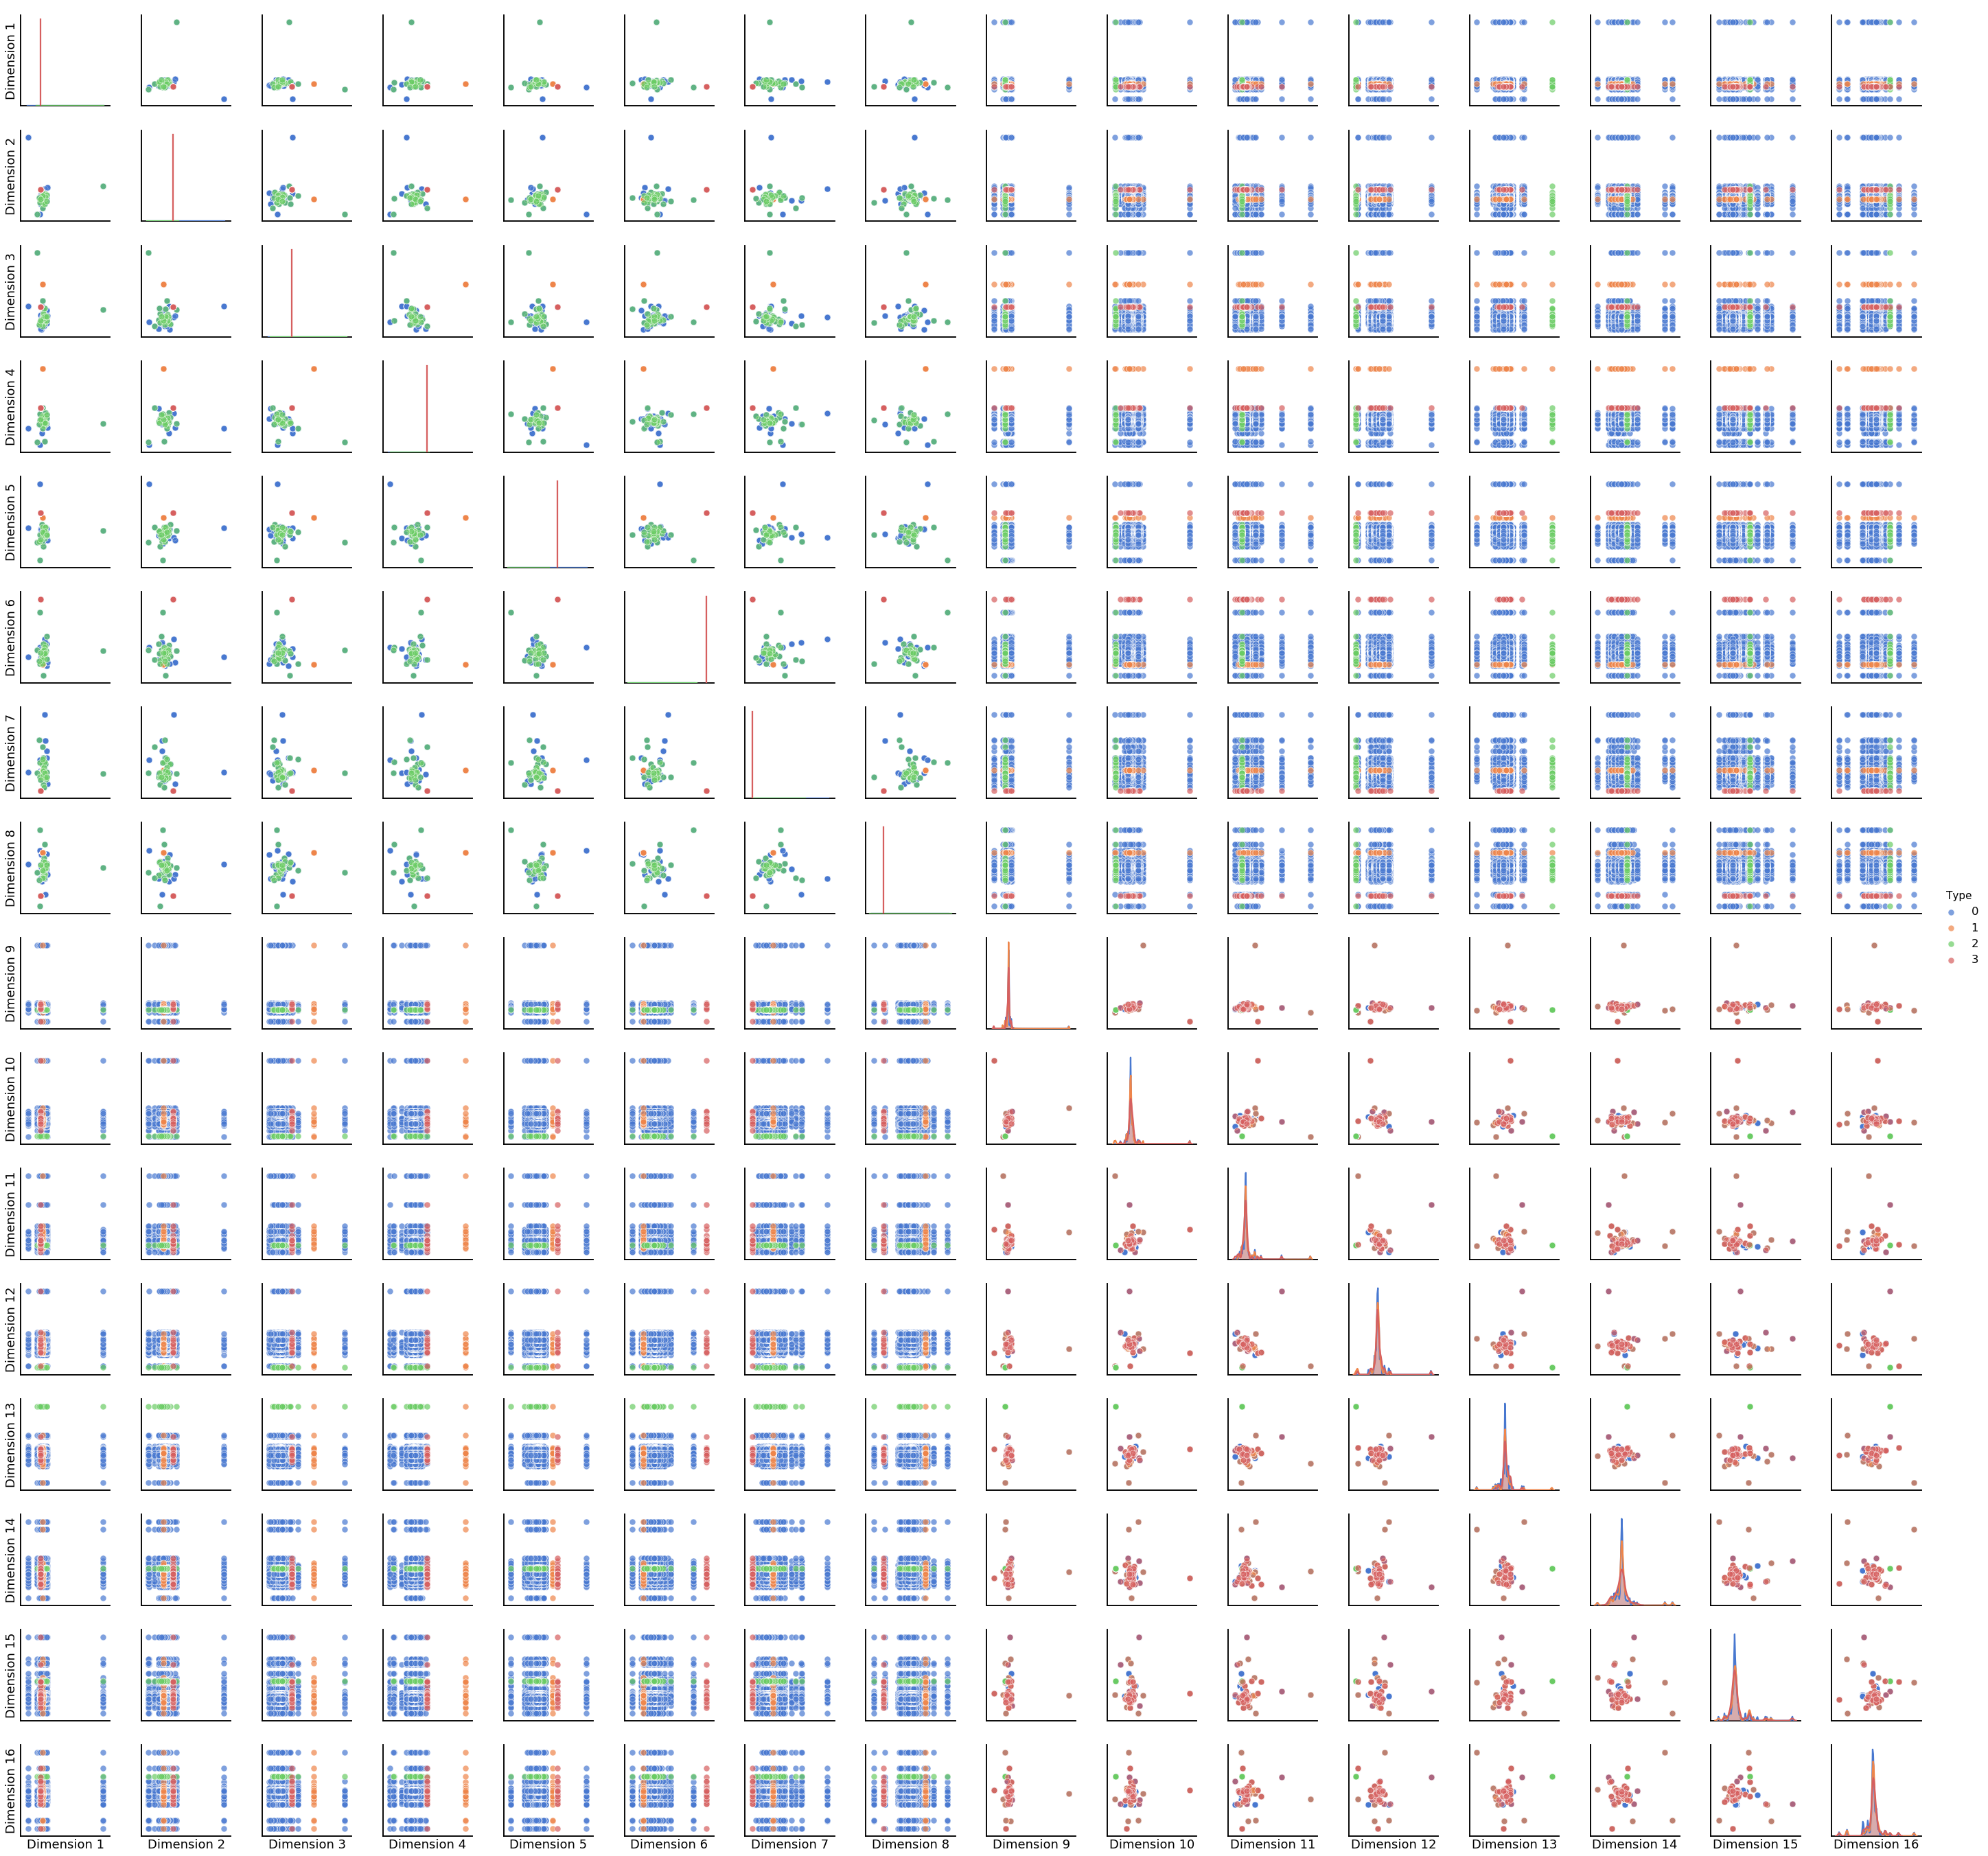

In [293]:
pairplot(ase_di,
         Y=ase_labels_di,
         title='',#ASE Embedded LineDiGraph colored by GMM labels',
         palette='muted')#.savefig("./plots./lse_pairplot_3by3_beta.png")

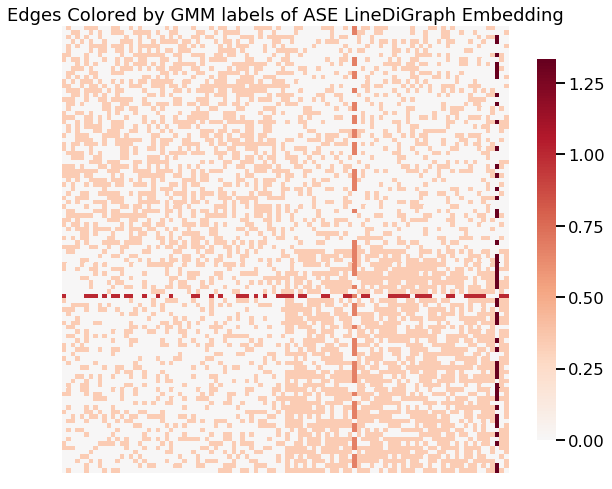

In [294]:
edgelabels2heatmap(beta_adj_di,ase_labels_di,edge_dict_di,title='Edges Colored by GMM labels of ASE LineDiGraph Embedding',directed=True)#.get_figure().savefig("./plots./lse_adj_heatmap_3by3_beta.png")

## Sparse Undirected Graph

In [304]:
ns = [50,50]
params = [[(2,7),(1,10)],[(1,10),(2,7)]]

In [305]:
sparse_adj = random_graph(ns,params,directed=False)
edge_dict_sparse,line_graph_sparse = lineGraph(sparse_adj)
n = None
lse_sparse = lapSE(n_components=n).fit_transform(line_graph_sparse)
lse_labels_sparse = graspy.cluster.GaussianCluster(3).fit_predict(lse_sparse)

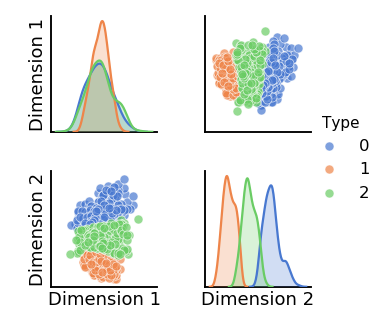

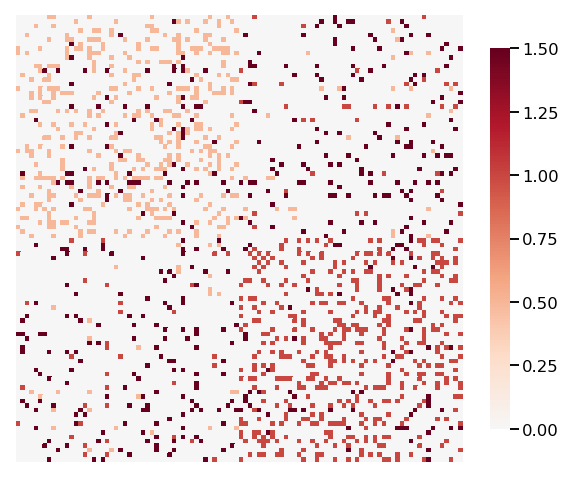

In [306]:
pairplot(lse_sparse,
         Y=lse_labels_sparse,
         title='',#LSE Embedded LineGraph colored by GMM labels',
         palette='muted')#.savefig("./plots./lse_pairplot_3by3_beta.png")
fig = edgelabels2heatmap(sparse_adj,lse_labels_sparse,edge_dict_sparse,title='',directed=False)#.get_figure().savefig("./plots./lse_adj_heatmap_3by3_beta.png")